In [2]:
import gensim
import os
from konlpy.tag import Mecab
from collections import Counter
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# 데이터 로드
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 데이터 전처리
# train_data 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
# test_data 확인
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [6]:
# train_data 결측값 개수 확인
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
# test_data 결측값 개수 확인
test_data.isna().sum()

id          0
document    3
label       0
dtype: int64

In [8]:
# train_data 중복 개수 확인
train_data.duplicated(keep = False).sum()

0

In [9]:
# test_data 중복 개수 확인
test_data.duplicated(keep = False).sum()

0

In [10]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
# Mecab api 정보 https://konlpy.org/ko/latest/api/konlpy.tag/#mecab-class
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [12]:
num_words = 10000

In [14]:
def get_encoded_word_vec(word_vec, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in word_vec]

In [15]:
def get_encoded_word_vecs(word_vecs, word_to_index):
    return [get_encoded_word_vec(word_vec, word_to_index) for word_vec in word_vecs]

In [16]:
def get_decoded_word_vec(enc_word_vec, index_to_word):
    return [index_to_word[index] if index in index_to_word else '<UNK>' for index in enc_word_vec[1:]]

In [17]:
def get_decoded_word_vecs(enc_word_vecs, index_to_word):
    return [get_decoded_word_vec(enc_word_vec, index_to_word) for enc_word_vec in enc_word_vecs]

In [20]:
def load_data(train_data, test_data, num_words):
    # 데이터 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_train.append([word for word in token_X if not word in stopwords])

    X_test = []
    for sentence in test_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_test.append([word for word in token_X if not word in stopwords])
    
    # 가장 빈도수가 높은 10000개 단어 선택
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)

    # 단어 사전 구성
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    index_to_word = {index : word for index, word in enumerate(vocab)}
    word_to_index = {word : index for index, word in enumerate(vocab)}

    X_train = get_encoded_word_vecs(X_train, word_to_index)
    X_test = get_encoded_word_vecs(X_test, word_to_index)
    y_train = list(train_data['label'])
    y_test = list(test_data['label'])
    
    return X_train, np.array(y_train), X_test, np.array(y_test), index_to_word, word_to_index

In [21]:
X_train, y_train, X_test, y_test, index_to_word, word_to_index = load_data(train_data, test_data, num_words)

In [22]:
# 텍스트데이터 문장길이 리스트 생성
num_tokens = [len(tokens) for tokens in (X_train + X_test)]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 최대 길이는 (평균 + 2*표준편차)로 설정
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print('maxlen :', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens) * 100 : .1f}%가 maxlen 설정값 이내에 포함')

문장길이 평균 : 16.96940191154864
문장길이 최대 : 117
문장길이 표준편차 : 12.843571191092
maxlen : 42
전체 문장의  93.1%가 maxlen 설정값 이내에 포함


In [23]:
# 최대 문장을 기준으로 padding 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [24]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(146182, 42) (146182,) (49157, 42) (49157,)


In [25]:
word_vector_dim = 16 # 워드 벡터의 차원 수

cnn_16 = tf.keras.Sequential(name='cnn_16')
cnn_16.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
cnn_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_16.add(tf.keras.layers.MaxPooling1D(5))
cnn_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_16.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_16.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_16.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_16.summary()

Model: "cnn_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9    

In [26]:
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

cnn_32 = tf.keras.Sequential(name='cnn_32')
cnn_32.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
cnn_32.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
cnn_32.add(tf.keras.layers.MaxPooling1D(5))
cnn_32.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_32.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_32.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_32.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

cnn_32.summary()

Model: "cnn_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9    

In [27]:
word_vector_dim = 16 # 워드 벡터의 차원 수

lstm = tf.keras.Sequential(name='lstm')
lstm.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(16))
lstm.add(tf.keras.layers.Dense(8, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [28]:
word_vector_dim = 16 # 워드 벡터의 차원 수

gmp = tf.keras.Sequential(name='gmp')
gmp.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
gmp.add(tf.keras.layers.GlobalMaxPooling1D())
gmp.add(tf.keras.layers.Dense(8, activation='relu'))
gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp.summary()

Model: "gmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [29]:
models = [cnn_16, cnn_32, lstm, gmp]

In [30]:
# validation set 분리
val_num = 50000
X_val = X_train[:val_num]
y_val = y_train[:val_num]

# validation set을 제외한 나머지
par_X_train = X_train[val_num:]  
par_y_train = y_train[val_num:]

history_dist = {}

In [31]:
for model in models:
    print(model.name, "train start")
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=10 

    history = model.fit(par_X_train,
                        np.array(par_y_train),
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

    history_dist[model.name] = history.history
    print()

cnn_16 train start
Epoch 1/10
188/188 [==============================] - 37s 8ms/step - loss: 0.5352 - accuracy: 0.7246 - val_loss: 0.3804 - val_accuracy: 0.8320
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3490 - accuracy: 0.8483 - val_loss: 0.3589 - val_accuracy: 0.8409
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3076 - accuracy: 0.8695 - val_loss: 0.3623 - val_accuracy: 0.8399
Epoch 4/10
188/188 [==============================] - 1s 5ms/step - loss: 0.2773 - accuracy: 0.8854 - val_loss: 0.3709 - val_accuracy: 0.8392
Epoch 5/10
188/188 [==============================] - 1s 5ms/step - loss: 0.2451 - accuracy: 0.9016 - val_loss: 0.3823 - val_accuracy: 0.8382
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2114 - accuracy: 0.9192 - val_loss: 0.4076 - val_accuracy: 0.8352
Epoch 7/10
188/188 [==============================] - 1s 5ms/step - loss: 0.1789 - accuracy: 0.9338 - val_loss: 0.4515 - val_acc

In [32]:
for model in models:
    print(model.name, "result")
    print(model.evaluate(X_test, y_test, verbose=2))
    print()

cnn_16 result
1537/1537 - 3s - loss: 0.5803 - accuracy: 0.8182
[0.5802658796310425, 0.818174421787262]

cnn_32 result
1537/1537 - 3s - loss: 0.7200 - accuracy: 0.8182
[0.7200276851654053, 0.818174421787262]

lstm result
1537/1537 - 3s - loss: 0.3824 - accuracy: 0.8399
[0.38242289423942566, 0.8398804068565369]

gmp result
1537/1537 - 2s - loss: 0.4081 - accuracy: 0.8352
[0.40814098715782166, 0.8351607918739319]



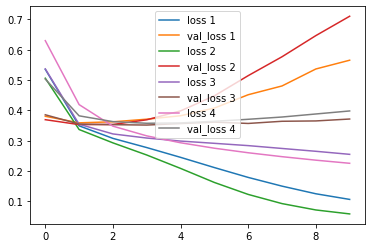

In [53]:
plt.clf()
i = 1
for model, history in history_dist.items():
    loss = history['loss']
    val_loss = history['val_loss'] 
    
    plt.plot(loss, label = 'loss '+str(i))
    plt.plot(val_loss, label = 'val_loss '+str(i))
    i += 1
    
plt.legend()

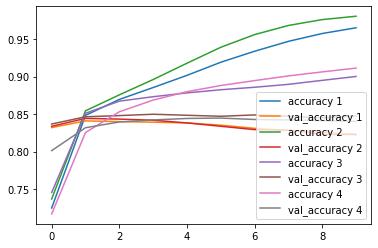

In [54]:
plt.clf()
i = 1
for model, history in history_dist.items():
    loss = history['accuracy']
    val_loss = history['val_accuracy'] 
    
    plt.plot(loss, label = 'accuracy '+str(i))
    plt.plot(val_loss, label = 'val_accuracy '+str(i))
    i += 1
    
plt.legend()